# torch.compile performance uplift validation
The following trainer validation, is used to compare performance differences between the following optimizations

- torch native
- torch + JIT
- torch + torch.compile

It presumes that basic setup has been done as per
- `./baseline-setup.ipynb`

To simplify the benchmarking, we are intentionally only performing
- training & data ctx len fixed at 4096
- a 100 trainer/global_step
- of 10 gradient accumulation (per GPU)
- no checkpoint save to disk (reduce the influence of random diskio in timings)

This would (on a single GPU) perform the run over
- a 1000 data samples


The following experiments were executed on a single `a10g` gpu `g5.8xlarge` AWS instance for consistency. With `deepspeed_stage_2_offload`

## Install the nightly build within conda
(Skip if you already have 2.1.0, or already done the setup)

For torch.compile, as of 8th July 2023, you will need the torch nightly build for several fixes we depend on. This is expected to be resolved when merged in for torch 2.1.0 release (you will need to perform this setup outside the notebook)

```bash
conda activate rwkv-infctx
conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch-nightly -c nvidia
```

## Configure and apply your preferred settings

Adjust your desired deepspeed settings, and gpu device count.
Enable/Disable WANDB here as well (recommended disabled, to reduce perf impact)

( note you will need to rerun this cell, if you restart your env )

In [15]:
DEEPSPEED_STRAT="deepspeed_stage_2_offload"
GPU_DEVICES="auto"
ENABLE_WANDB=False

print("DEEPSPEED_STRAT:", DEEPSPEED_STRAT)
print("ENABLE_WANDB:", ENABLE_WANDB)
print("GPU_DEVICES:", GPU_DEVICES)

if ENABLE_WANDB:
    WANDB_MODE="online"
else:
    WANDB_MODE="disabled"

# Ensure logs dir is initialized
!mkdir -p ./logs/

DEEPSPEED_STRAT: deepspeed_stage_2_offload
ENABLE_WANDB: False
GPU_DEVICES: auto


## Preload your data
The data has minor differences from baseline, and needs to be preloaded here

In [2]:
!cd ../../RWKV-v4neo && python3 preload_dataset.py ../notebook/trainer-validation/config/torch-compile-perf.yaml

Found cached dataset parquet (/home/ubuntu/.cache/huggingface/datasets/teven___parquet/teven--enwiki_10k-de63a925546e70ab/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 973.16it/s]
Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/teven___parquet/teven--enwiki_10k-de63a925546e70ab/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-a9b10ddaafcd70a8_*_of_00032.arrow
Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/teven___parquet/teven--enwiki_10k-de63a925546e70ab/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-cfd32fc41583b797_*_of_00032.arrow
Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/teven___parquet/teven--enwiki_10k-de63a925546e70ab/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-f22a54fa61543287_*_of_00032.arrow


## Perform baseline benchmark (no JIT / no toch compile)

In [12]:
!cd ../../RWKV-v4neo && \
    touch ../notebook/trainer-validation/logs/torch-compile-perf_baseline.log && \
    export RWKV_TORCH_COMPILE=0 && \
    export RWKV_JIT_ON=0 && \
    export WANDB_MODE="{WANDB_MODE}" && \
    python3 new_train.py fit \
        -c ../notebook/trainer-validation/config/torch-compile-perf.yaml \
        --trainer.logger.init_args.name="infctx-torch-compile-perf (no JIT / no torch compile)" \
        --trainer.strategy="{DEEPSPEED_STRAT}" \
        --trainer.devices="{GPU_DEVICES}" \
    | tee ../notebook/trainer-validation/logs/torch-compile-perf_baseline.log

[2023-07-08 05:13:47,599] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[RWKV.model] Running RWKV model with : torch-native
Global seed set to 3941088705
Using /home/ubuntu/.cache/torch_extensions/py311_cu118 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/ubuntu/.cache/torch_extensions/py311_cu118/wkv_4096_bf16/build.ninja...
Building extension module wkv_4096_bf16...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module wkv_4096_bf16...
/home/ubuntu/anaconda3/envs/rwkv-infctx/lib/python3.11/site-packages/lightning/fabric/connector.py:555: UserWarning: bf16 is supported for historical reasons but its usage is discouraged. Please set your precision to bf16-mixed instead!
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: 

## Perform JIT benchmark

In [37]:
!cd ../../RWKV-v4neo && \
    touch ../notebook/trainer-validation/logs/torch-compile-perf_jit.log && \
    export RWKV_TORCH_COMPILE=0 && \
    export RWKV_JIT_ON=1 && \
    export WANDB_MODE="{WANDB_MODE}" && \
    python3 new_train.py fit \
        -c ../notebook/trainer-validation/config/torch-compile-perf.yaml \
        --trainer.logger.init_args.name="infctx-torch-compile-perf (with JIT)" \
        --trainer.strategy="{DEEPSPEED_STRAT}" \
        --trainer.devices="{GPU_DEVICES}" \
    | tee ../notebook/trainer-validation/logs/torch-compile-perf_jit.log

[2023-07-08 07:01:31,337] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[RWKV.model] Running RWKV model via the following optimization mode : torch-jit
Global seed set to 3941088705
Using /home/ubuntu/.cache/torch_extensions/py311_cu118 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/ubuntu/.cache/torch_extensions/py311_cu118/wkv_4096_bf16/build.ninja...
Building extension module wkv_4096_bf16...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module wkv_4096_bf16...
/home/ubuntu/anaconda3/envs/rwkv-infctx/lib/python3.11/site-packages/lightning/fabric/connector.py:555: UserWarning: bf16 is supported for historical reasons but its usage is discouraged. Please set your precision to bf16-mixed instead!
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using:

## Perform Torch.compile benchmark

Reminder: You will need either pytorch nightly OR pytorch 2.1.0

In [36]:
!cd ../../RWKV-v4neo && \
    touch ../notebook/trainer-validation/logs/torch-compile-perf_torch-compile.log && \
    export RWKV_TORCH_COMPILE=1 && \
    export RWKV_JIT_ON=0 && \
    export WANDB_MODE="{WANDB_MODE}" && \
    python3 new_train.py fit \
        -c ../notebook/trainer-validation/config/torch-compile-perf.yaml \
        --trainer.logger.init_args.name="infctx-torch-compile-perf (with torch.compile)" \
        --trainer.strategy="{DEEPSPEED_STRAT}" \
        --trainer.devices="{GPU_DEVICES}" \
    | tee ../notebook/trainer-validation/logs/torch-compile-perf_torch-compile.log

[2023-07-08 06:36:18,883] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[RWKV.model] Running RWKV model via the following optimization mode : torch-compile
Global seed set to 3941088705
Using /home/ubuntu/.cache/torch_extensions/py311_cu118 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/ubuntu/.cache/torch_extensions/py311_cu118/wkv_4096_bf16/build.ninja...
Building extension module wkv_4096_bf16...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module wkv_4096_bf16...
/home/ubuntu/anaconda3/envs/rwkv-infctx/lib/python3.11/site-packages/lightning/fabric/connector.py:555: UserWarning: bf16 is supported for historical reasons but its usage is discouraged. Please set your precision to bf16-mixed instead!
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, us

# Lets compare the numbers!

Because we are not using WANDB for this benchmark, lets crunch the logs for the numbers we need!

In [50]:
# Install matlab plotting library
!python3 -m pip install matplotlib

In [76]:
# First we need to extract the numbers from the logs
import re

def convert_time_to_seconds(time_str):
    t = list(map(int, time_str.split(':')))
    return sum([a*b for (a,b) in zip(t[::-1], (1, 60, 3600))])

def extract_from_training_logs(log_file):
    result = []
    with open(log_file, 'r') as file:
        for line in file.readlines():
            # Check if the line starts with "Epoch 0:"
            if line.startswith("Epoch 0:"):
                iteration = re.search(r'(?<=\| )(\d+)', line)   # Extracts the iteration number
                time_spent = re.search(r'(?<=\[)(.*?)(?=<)', line)    # Extracts the time spent so far
                loss = re.search(r'(?<=train/loss=)(\d+.\d+)', line)  # Extracts the train/loss number
      
                if iteration and time_spent and loss:
                    result.append({
                        "it": int(iteration.group(0)), 
                        "time": convert_time_to_seconds(time_spent.group(0)),
                        "s_time": time_spent.group(0),
                        "loss": float(loss.group(0))
                    })
    return result


# Extract the numbers
step_baseline = extract_from_training_logs("./logs/torch-compile-perf_baseline.log")
step_jit = extract_from_training_logs("./logs/torch-compile-perf_jit.log")
step_tcompile = extract_from_training_logs("./logs/torch-compile-perf_torch-compile.log")

# Print the high level numbers (quick debugging, if log has issues)
print("First step figures ...")
print("Baseline: ", step_baseline[0])
print("JIT: ", step_jit[0])
print("Torch Compile: ", step_tcompile[0])
print("")
print("Last step figures ...")
print("Baseline: ", step_baseline[-1])
print("JIT: ", step_jit[-1])
print("Torch Compile: ", step_tcompile[-1])


First step figures ...
Baseline:  {'it': 1, 'time': 10, 's_time': '00:10', 'loss': 10.9}
JIT:  {'it': 1, 'time': 12, 's_time': '00:12', 'loss': 10.9}
Torch Compile:  {'it': 1, 'time': 80, 's_time': '01:20', 'loss': 10.9}

Last step figures ...
Baseline:  {'it': 1000, 'time': 1466, 's_time': '24:26', 'loss': 6.62}
JIT:  {'it': 1000, 'time': 1408, 's_time': '23:28', 'loss': 6.66}
Torch Compile:  {'it': 1000, 'time': 1433, 's_time': '23:53', 'loss': 6.69}


# Check if the loss plot is similar

No point having a faster JIT / torch.compile, if the loss curve does not fall at the same rate

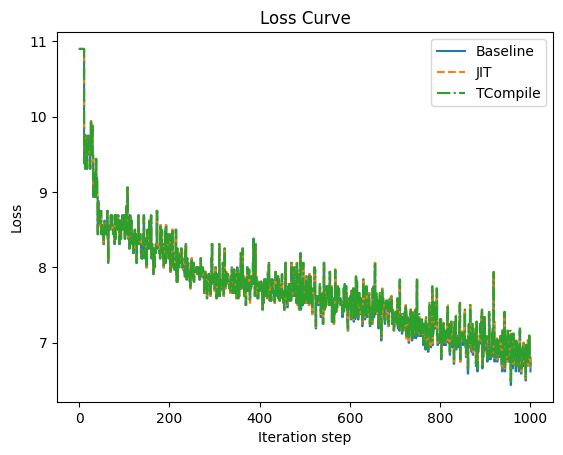

In [56]:
# Plot the loss curve
import matplotlib.pyplot as plt

# Extract iteration and loss values for each method
it_baseline = [entry['it'] for entry in step_baseline]
loss_baseline = [entry['loss'] for entry in step_baseline]

it_jit = [entry['it'] for entry in step_jit]
loss_jit = [entry['loss'] for entry in step_jit]

it_tcompile = [entry['it'] for entry in step_tcompile]
loss_tcompile = [entry['loss'] for entry in step_tcompile]

# Plot loss curves
plt.plot(it_baseline, loss_baseline, label="Baseline", linestyle='-')
plt.plot(it_jit, loss_jit, label="JIT", linestyle='--')
plt.plot(it_tcompile, loss_tcompile, label="TCompile", linestyle='-.')

plt.xlabel('Iteration step')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.show()

If everything is working as designed, it should be nearly impossible to see the differences between the 3 lines. So lets plot the delta against baseline instead.

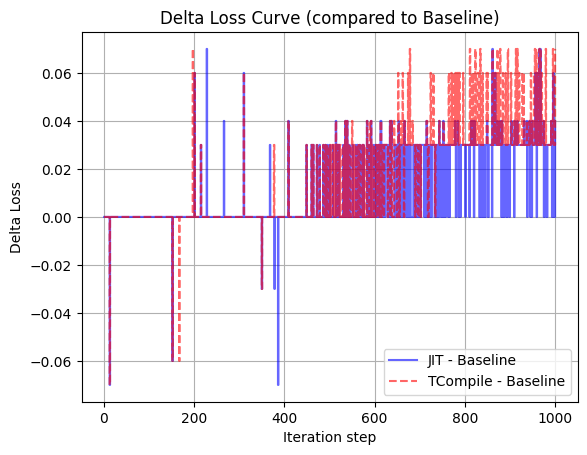

In [67]:
import numpy as np

# Convert lists to numpy arrays for easier manipulation
loss_baseline_np = np.array(loss_baseline)
loss_jit_np = np.array(loss_jit)
loss_tcompile_np = np.array(loss_tcompile)

# Calculate deltas
delta_jit_baseline = (loss_jit_np - loss_baseline_np)
delta_tcompile_baseline = (loss_tcompile_np - loss_baseline_np)

# Plot deltas
plt.plot(it_jit, delta_jit_baseline, label="JIT - Baseline", linestyle='-', color='blue', alpha=0.6)
plt.plot(it_tcompile, delta_tcompile_baseline, label="TCompile - Baseline", linestyle='--', color='red', alpha=0.6)

plt.xlabel('Iteration step')
plt.ylabel('Delta Loss')
plt.title('Delta Loss Curve (compared to Baseline)')
plt.legend()
plt.grid(True)
plt.show()

If everything is working as per designed, the differences between "Delta Loss" should be within margin of error, of run-by-run varience

# Plot the time charts!

Lets start with a basic iteration step over cummulative time

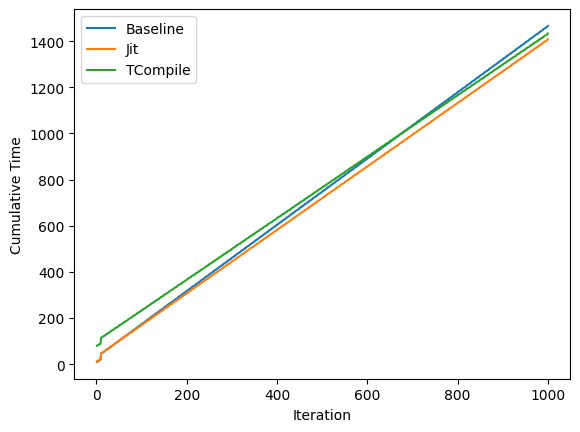

In [77]:
import matplotlib.pyplot as plt

# Extract the 'it' and 'time' values from each dictionary in each list
it_baseline = [x['it'] for x in step_baseline]
time_baseline = [x['time'] for x in step_baseline]

it_jit = [x['it'] for x in step_jit]
time_jit = [x['time'] for x in step_jit]

it_tcompile = [x['it'] for x in step_tcompile]
time_tcompile = [x['time'] for x in step_tcompile]

# Plot cumulative time for each iteration
plt.plot(it_baseline, time_baseline, label='Baseline')
plt.plot(it_jit, time_jit, label='Jit')
plt.plot(it_tcompile, time_tcompile, label='TCompile')

# Label the axes
plt.xlabel('Iteration')
plt.ylabel('Cumulative Time')

# Add a legend
plt.legend(loc='upper left')

# Display the plot
plt.show()

If everything is working correctly it should show that

- baseline: lowest starting time, highest accumulative rate
- JIT: similar starting time, lower accumulative rate
- TCompile: slowest starting time, lowest accumulative rate

This can be observed by getting the average time per iteration for the first 200 steps and the last 800 steps

In [83]:
# Compute the average time for the first `n` iterations and for the rest
def compute_average_delta(data, n):
    time = [x['time'] for x in data]
    avg_first_n = (time[n-1] - time[0]) / n if n > 0 else 0
    avg_remaining = (time[-1] - time[n]) / (len(time)-n) if (len(time)-n) != 0 else 0
    return avg_first_n, avg_remaining

n = 200
avg_delta_baseline = compute_average_delta(step_baseline, n)
avg_delta_jit = compute_average_delta(step_jit, n)
avg_delta_tcompile = compute_average_delta(step_tcompile, n)

print("Average delta time for the first 200 iterations ('warmup'):")
print(f"Baseline: {avg_delta_baseline[0] * 1000} ms")
print(f"Jit:      {avg_delta_jit[0] * 1000} ms")
print(f"TCompile: {avg_delta_tcompile[0] * 1000} ms")
print("")

print("Average delta time after 'warmup':")
print(f"Baseline: {avg_delta_baseline[1] * 1000} ms")
print(f"Jit:      {avg_delta_jit[1] * 1000} ms")
print(f"TCompile: {avg_delta_tcompile[1] * 1000} ms")



Average delta time for the first 200 iterations:
Baseline: 830.0 ms
Jit:      800.0 ms
TCompile: 775.0 ms

Average delta time after 'warmup':
Baseline: 716.2687395891172 ms
Jit:      686.2853970016657 ms
TCompile: 665.1860077734592 ms
